# 학습 목표
1. Transformer 아키텍처를 활용한 분자 생성 방법 이해
2. Hugging Face 라이브러리를 사용한 모델 구현
3. 사전 훈련된 모델을 활용한 분자 생성 및 미세 조정

# 1. Transformer 기반 분자 생성 모델의 장점:
- SMILES 내 거리가 먼 원자 간의 관계도 효과적으로 학습
- 화학적 문법 규칙을 더 잘 포착
- 대규모 분자 데이터셋에서 효율적으로 학습 가능
- 전이학습(Transfer Learning)을 통한 적은 데이터로도 효과적인 모델 구축 가능

# 2. 주요 모델:
- SMILES-Transformer
- MolGPT
- MolFormer
- ChemBERTa

Adilov, S. (2021). Generative pre-training from molecules.

https://chemrxiv.org/engage/chemrxiv/article-details/6142f60742198e8c31782e9e

https://github.com/sanjaradylov/smiles-gpt?tab=readme-ov-file

    from transformers import GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast

    checkpoint = "checkpoints/benchmark-5m"

    config = GPT2Config.from_pretrained(checkpoint)
    model = GPT2LMHeadModel.from_pretrained(checkpoint)
    tokenizer = PreTrainedTokenizerFast.from_pretrained(checkpoint)


GPT2 Zinc 87m
This is a GPT2 style autoregressive language model trained on ~480m SMILES strings from the ZINC database.

The model has ~87m parameters and was trained for 175000 iterations with a batch size of 3072 to a validation loss of ~.615. This model is useful for generating druglike molecules or generating embeddings from SMILES strings

https://huggingface.co/entropy/gpt2_zinc_87m

# 3. 실습

## 2.1. 라이브러리 설치 및 불러오기

In [ ]:
# 필요한 라이브러리 설치
!pip install rdkit datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Lipinski, AllChem
from rdkit.Chem import DataStructs
from tqdm.auto import tqdm
import time
import random
from collections import Counter
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 장치: {device}")

사용 중인 장치: cuda


## 2.2. 모델 불러오기

In [ ]:
# 모델 및 토크나이저 로드
print("GPT-2 ZINC 모델 로딩 중...")
model_name = "entropy/gpt2_zinc_87m"

tokenizer = GPT2TokenizerFast.from_pretrained(model_name, max_len=256)
model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

print(f"모델 로드 완료: {model_name}")
print(f"어휘 크기: {len(tokenizer)}")

# 토크나이저 설정 확인
print(f"\n특수 토큰:")
print(f"BOS 토큰: {tokenizer.bos_token}, ID: {tokenizer.bos_token_id}")
print(f"EOS 토큰: {tokenizer.eos_token}, ID: {tokenizer.eos_token_id}")
print(f"PAD 토큰: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}")

# PAD 토큰이 없으면 설정
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"PAD 토큰을 EOS 토큰으로 설정: {tokenizer.pad_token}")

GPT-2 ZINC 모델 로딩 중...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

모델 로드 완료: entropy/gpt2_zinc_87m
어휘 크기: 2707

특수 토큰:
BOS 토큰: <s>, ID: 0
EOS 토큰: </s>, ID: 2
PAD 토큰: <pad>, ID: 1


## 2.3. 분자 생성 함수 구현

In [ ]:
# 분자 생성 함수
def generate_molecules(model, tokenizer, n_samples=10, max_length=256,
                      temperature=1.0, top_k=50, top_p=0.95,
                      do_sample=True, batch_size=8):
    """
    Transformer 모델을 사용하여 분자 생성

    Args:
        model: 허깅페이스 모델
        tokenizer: 허깅페이스 토크나이저
        n_samples: 생성할 분자 수
        max_length: 생성할 최대 토큰 수
        temperature: 샘플링 온도 (높을수록 다양한 결과)
        top_k: 상위 k개 토큰만 샘플링 고려
        top_p: 누적 확률이 p를 초과할 때까지의 토큰만 샘플링 고려
        do_sample: True면 확률적 샘플링, False면 그리디 디코딩
        batch_size: 한 번에 생성할 분자 수

    Returns:
        생성된 SMILES 문자열 목록
    """
    generated_smiles = []
    n_batches = (n_samples + batch_size - 1) // batch_size  # 올림 나눗셈

    # 배치 단위로 생성
    for _ in tqdm(range(n_batches), desc="분자 생성 중"):
        # 현재 배치 크기 계산 (마지막 배치는 작을 수 있음)
        current_batch_size = min(batch_size, n_samples - len(generated_smiles))

        # bos_token_id로 입력 초기화
        inputs = torch.tensor([[tokenizer.bos_token_id]] * current_batch_size).to(device)

        # 분자 생성
        with torch.no_grad():
            outputs = model.generate(
                inputs,
                do_sample=do_sample,
                max_length=max_length,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                num_return_sequences=1
            )

        # 생성된 시퀀스 디코딩 (특수 토큰 제거)
        batch_smiles = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        generated_smiles.extend(batch_smiles)

    return generated_smiles

# 분자 유효성 확인 함수
def check_validity(smiles_list):
    """생성된 SMILES의 유효성 확인"""
    valid_mols = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            valid_mols.append((smile, mol))

    validity_ratio = len(valid_mols) / len(smiles_list) if smiles_list else 0
    return valid_mols, validity_ratio

# 분자 특성 계산 함수
def calculate_properties(mols):
    """분자의 다양한 특성 계산"""
    properties = []

    for smile, mol in mols:
        # 기본 특성 계산
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Lipinski.NumHDonors(mol)
        h_acceptors = Lipinski.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)

        # Lipinski 규칙 검사
        lipinski_violations = 0
        if mw > 500: lipinski_violations += 1
        if logp > 5: lipinski_violations += 1
        if h_donors > 5: lipinski_violations += 1
        if h_acceptors > 10: lipinski_violations += 1

        properties.append({
            'SMILES': smile,
            'MolWt': mw,
            'LogP': logp,
            'TPSA': tpsa,
            'HBD': h_donors,
            'HBA': h_acceptors,
            'RotBonds': rotatable_bonds,
            'Lipinski_Violations': lipinski_violations
        })

    return pd.DataFrame(properties)

## 2.4. 다양한 파라미터로 분자 생성 및 평가


온도 매개변수: 0.5


분자 생성 중:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


생성 시간: 9.95초 (0.20초/분자)
생성된 분자 수: 50
유니크 분자 수: 50
유니크 비율: 100.00%
유효한 분자 수: 50
유효성 비율: 100.00%
유효하고 유니크한 분자 비율: 100.00%

분자 특성 요약:
            MolWt       LogP        TPSA       HBD        HBA   RotBonds  \
count   50.000000  50.000000   50.000000  50.00000  50.000000  50.000000   
mean   368.448780   2.620251   74.132800   1.40000   3.860000   4.080000   
std     42.234236   1.026089   21.737785   0.92582   1.261842   1.440521   
min    292.398000   0.555340   40.620000   0.00000   1.000000   1.000000   
25%    342.395250   1.902950   59.670000   1.00000   3.000000   3.000000   
50%    356.436500   2.534750   72.970000   1.00000   4.000000   4.000000   
75%    397.371000   3.271830   88.182500   2.00000   4.000000   5.000000   
max    472.523000   4.976100  128.520000   4.00000   8.000000   7.000000   

       Lipinski_Violations  
count                 50.0  
mean                   0.0  
std                    0.0  
min                    0.0  
25%                    0.0  
50%       

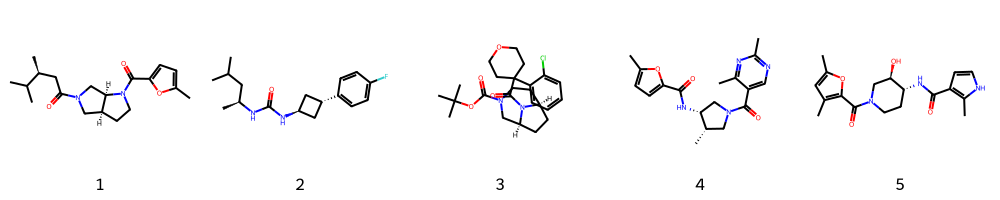


온도 매개변수: 0.75


분자 생성 중:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


생성 시간: 6.56초 (0.13초/분자)
생성된 분자 수: 50
유니크 분자 수: 50
유니크 비율: 100.00%
유효한 분자 수: 50
유효성 비율: 100.00%
유효하고 유니크한 분자 비율: 100.00%

분자 특성 요약:
            MolWt       LogP        TPSA        HBD        HBA   RotBonds  \
count   50.000000  50.000000   50.000000  50.000000  50.000000  50.000000   
mean   379.062300   2.491301   75.028400   1.340000   4.520000   5.020000   
std     52.128082   1.353753   16.901884   0.847806   1.568048   1.696214   
min    282.384000  -0.584100   35.580000   0.000000   2.000000   2.000000   
25%    342.690000   1.401475   64.287500   1.000000   3.000000   4.000000   
50%    364.862500   2.648350   76.460000   1.000000   4.000000   5.000000   
75%    418.109750   3.510575   85.020000   2.000000   5.000000   6.000000   
max    496.583000   5.290400  117.420000   3.000000   8.000000   8.000000   

       Lipinski_Violations  
count            50.000000  
mean              0.020000  
std               0.141421  
min               0.000000  
25%               0.000000  
5

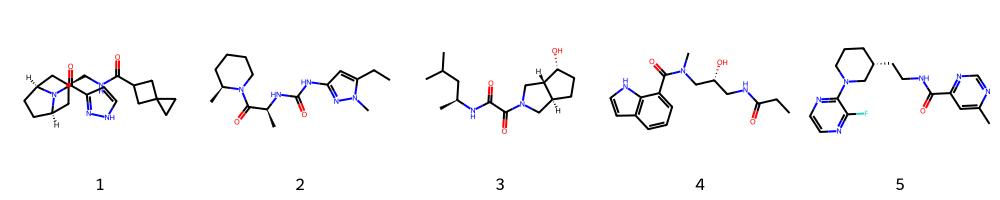


온도 매개변수: 1.0


분자 생성 중:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


생성 시간: 5.32초 (0.11초/분자)
생성된 분자 수: 50
유니크 분자 수: 50
유니크 비율: 100.00%
유효한 분자 수: 50
유효성 비율: 100.00%
유효하고 유니크한 분자 비율: 100.00%

분자 특성 요약:
            MolWt       LogP        TPSA        HBD        HBA   RotBonds  \
count   50.000000  50.000000   50.000000  50.000000  50.000000  50.000000   
mean   368.764640   2.425057   77.821800   1.400000   4.800000   5.780000   
std     53.086375   1.334809   19.133152   0.880631   1.340119   2.043307   
min    266.288000  -0.430420   41.370000   0.000000   2.000000   2.000000   
25%    334.914000   1.518050   63.412500   1.000000   4.000000   4.250000   
50%    359.149500   2.643850   78.220000   1.000000   5.000000   6.000000   
75%    413.479250   3.330430   90.650000   2.000000   5.750000   7.000000   
max    473.595000   5.121140  123.140000   3.000000   8.000000  10.000000   

       Lipinski_Violations  
count            50.000000  
mean              0.020000  
std               0.141421  
min               0.000000  
25%               0.000000  
5

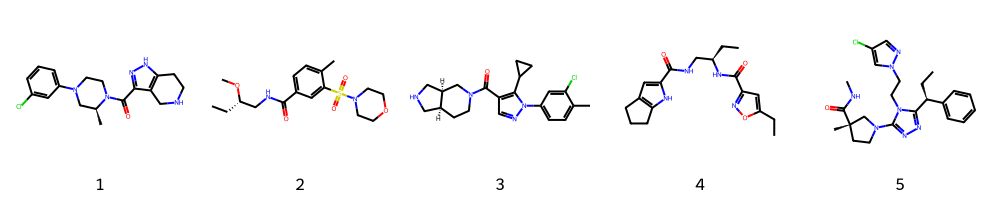


온도 매개변수: 1.25


분자 생성 중:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


생성 시간: 3.15초 (0.06초/분자)
생성된 분자 수: 50
유니크 분자 수: 50
유니크 비율: 100.00%
유효한 분자 수: 50
유효성 비율: 100.00%
유효하고 유니크한 분자 비율: 100.00%

분자 특성 요약:
            MolWt       LogP        TPSA        HBD        HBA   RotBonds  \
count   50.000000  50.000000   50.000000  50.000000  50.000000  50.000000   
mean   368.092160   2.608174   71.859800   1.400000   4.820000   6.080000   
std     50.487944   1.506048   25.374078   0.947607   1.923963   2.202411   
min    258.274000  -1.550700    6.480000   0.000000   2.000000   1.000000   
25%    332.212250   1.916600   53.637500   1.000000   3.000000   5.000000   
50%    368.398000   2.665970   72.545000   1.000000   5.000000   6.000000   
75%    406.502000   3.572735   86.100000   2.000000   6.000000   7.000000   
max    489.642000   5.688300  131.150000   4.000000   9.000000  10.000000   

       Lipinski_Violations  
count            50.000000  
mean              0.020000  
std               0.141421  
min               0.000000  
25%               0.000000  
5

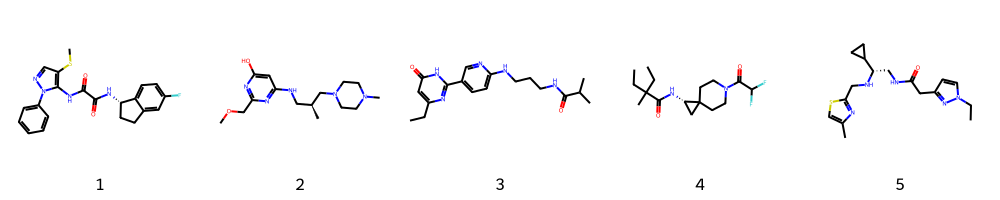

In [ ]:
# 다양한 온도 매개변수로 분자 생성 및 평가
temperature_values = [0.5, 0.75, 1.0, 1.25]
n_samples = 50  # 각 온도당 생성할 분자 수

results = {}

for temp in temperature_values:
    print(f"\n온도 매개변수: {temp}")

    # 분자 생성
    start_time = time.time()
    generated_smiles = generate_molecules(
        model, tokenizer,
        n_samples=n_samples,
        temperature=temp,
        top_k=50,
        top_p=0.95
    )
    end_time = time.time()

    # 생성 시간 계산
    generation_time = end_time - start_time
    print(f"생성 시간: {generation_time:.2f}초 ({generation_time/n_samples:.2f}초/분자)")

    # 유니크 SMILES 수 계산
    unique_smiles = list(set(generated_smiles))
    uniqueness_ratio = len(unique_smiles) / len(generated_smiles)
    print(f"생성된 분자 수: {len(generated_smiles)}")
    print(f"유니크 분자 수: {len(unique_smiles)}")
    print(f"유니크 비율: {uniqueness_ratio:.2%}")

    # 유효성 검사
    valid_mols, validity_ratio = check_validity(unique_smiles)
    print(f"유효한 분자 수: {len(valid_mols)}")
    print(f"유효성 비율: {validity_ratio:.2%}")

    # 최종 유효하고 유니크한 분자 비율
    valid_and_unique_ratio = len(valid_mols) / len(generated_smiles)
    print(f"유효하고 유니크한 분자 비율: {valid_and_unique_ratio:.2%}")

    # 특성 계산
    if valid_mols:
        props_df = calculate_properties(valid_mols)
        results[temp] = {
            'smiles': generated_smiles,
            'unique_smiles': unique_smiles,
            'valid_mols': valid_mols,
            'uniqueness_ratio': uniqueness_ratio,
            'validity_ratio': validity_ratio,
            'valid_and_unique_ratio': valid_and_unique_ratio,
            'properties': props_df
        }

        # 특성 요약
        print("\n분자 특성 요약:")
        print(props_df.describe())

        # 일부 분자 시각화
        if len(valid_mols) >= 5:
            mols_to_draw = [mol for _, mol in valid_mols[:5]]
            img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200, 200), legends=[f"{i+1}" for i in range(5)])
            display(img)